In [1]:
import numpy as np
import scipy.sparse as sp
import sknetwork as sn
import numba
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import f1_score as F1
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

from abcd_graph import ABCDGraph, ABCDParams
from partition_sknetwork import ECG
from tqdm import tqdm
import CAS
import community_evaluation as ce

In [2]:
# We tend to get divide by 0 warnings, but they are corretly set to inf
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Quality Test

Test the AUC of each CAS score vs. actually belonging to the cluster using the real labels.

In [4]:
@numba.njit
def _get_cas_work(
    n_labels,
    labels_indptr,
    labels_indices,
    adjacency_indptr,
    adjacency_indices,
    adjacency_data,
):
    node_labels = CAS.cas_._make_node_label_sets(
        labels_indptr, labels_indices, len(adjacency_indptr) - 1
    )
    graph_volume = np.sum(adjacency_data)
    # Cache label volumes
    label_volumes = np.zeros(n_labels, dtype="float32")
    for node, nl in enumerate(node_labels):
        degree = CAS.cas_._get_degree(
            node, adjacency_indptr, adjacency_indices, adjacency_data
        )
        for label in nl:
            label_volumes[label] += degree
    assert graph_volume > 0
    label_volumes /= graph_volume

    # Compute Scores
    iefs = numba.typed.List.empty_list(numba.types.float64[:])
    niefs = numba.typed.List.empty_list(numba.types.float64[:])
    ps = numba.typed.List.empty_list(numba.types.float64[:])
    results = numba.typed.List.empty_list(numba.types.bool[:])

    for node, labels in enumerate(node_labels):
        plausible_labels = labels.copy()
        plausible_labels = node_labels[node].copy()
        neighbors = adjacency_indices[
            adjacency_indptr[node] : adjacency_indptr[node + 1]
        ]
        for neighbor in neighbors:
            plausible_labels.update(node_labels[neighbor])
        plausible_labels = list(plausible_labels)
        result = np.empty(len(plausible_labels), dtype="bool")
        ief = np.empty(len(plausible_labels), dtype="float64")
        nief = np.empty(len(plausible_labels), dtype="float64")
        p = np.empty(len(plausible_labels), dtype="float64")
        for i, label in enumerate(plausible_labels):
            result[i] = label in labels
            ief[i] = CAS.cas_._ief(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
            nief[i] = CAS.cas_._nief(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
            p[i] = CAS.cas_._p(
                node,
                label,
                label_volumes[label],
                node_labels,
                adjacency_indptr,
                adjacency_indices,
                adjacency_data,
            )
        results.append(result)
        iefs.append(ief)
        niefs.append(nief)
        ps.append(p)

    return results, iefs, niefs, ps


def get_cas_and_result(labels, adjacency):
    # Assume labels is a numpy array of a partition
    # return a numpy array with the cas score to each label
    labels_matrix = labels.tocsc()
    r, i, n, p = _get_cas_work(
        labels.shape[0],
        labels_matrix.indptr,
        labels_matrix.indices,
        adjacency.indptr,
        adjacency.indices,
        adjacency.data,
    )
    return np.hstack(r), np.hstack(i), np.hstack(n), np.hstack(p)

Text(0.5, 0.98, 'AUC for Community Membership on ABCD+o')

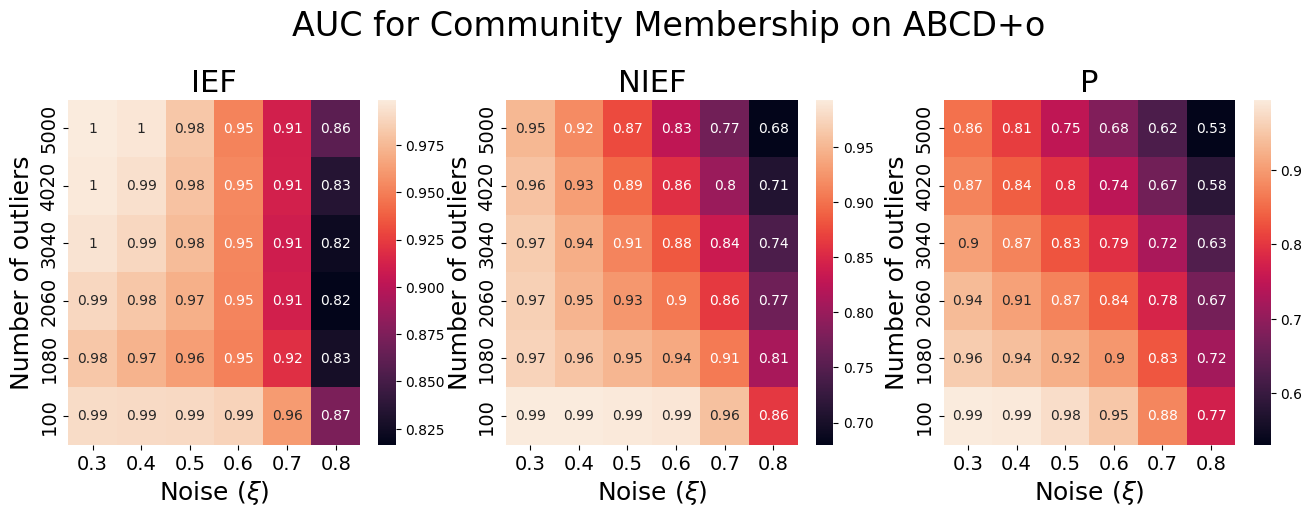

In [12]:
## For each CAS, make a heatmap of average AUC score
REP = 10
n = 10000
XIS = np.round(np.linspace(0.3, 0.8, 6), 2)
NOUTS = np.round(np.linspace(n / 100, n / 2, 6)).astype("int32")

ief_aucs = np.empty((len(XIS), len(NOUTS), REP))
nief_aucs = np.empty((len(XIS), len(NOUTS), REP))
p_aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS) * len(NOUTS) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n,
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**0.5),
                    beta=1.5,
                    min_community_size=25,
                    max_community_size=int(n**0.767),
                    xi=xi,
                    num_outliers=nout,
                )
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array(
                    [i for i, com in enumerate(G.communities) for _ in com.vertices]
                )
                labels = CAS.cas_.labels_array_to_matrix(labels)
                res, ief, nief, p = get_cas_and_result(labels, adjacency)
                ief_aucs[i, j, k] = AUC(res, ief)
                nief_aucs[i, j, k] = AUC(res, nief)
                p_aucs[i, j, k] = AUC(res, p)
                pbar.update()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[0],
)
axs[0].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[0].set_ylabel("Number of outliers", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[1],
)
axs[1].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[1].set_ylabel("Number of outliers", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[2],
)
axs[2].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[2].set_ylabel("Number of outliers", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("AUC for Community Membership on ABCD+o", fontsize=24, y=0.98)
# fig.set_dpi(200)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

# Threshold effect on ABCD+o benchmark
Test the effect of choosing a threshold from pruning on ABCD+o graphs.
We hope to see that increaseing the threshold results in more outliers and a more correct non-oulier clustering.

In [7]:
REP = 30
n = 10000
ief_thresholds = np.linspace(0.1, 0.5, 30)
p_thresholds = np.linspace(0.8, 0.999, 30)

# Store (Cluster F1s, % Outlier, F1) in first axis, theshold in second axis, REP in third axis
ief = np.zeros((2, 3, len(ief_thresholds), REP))
nief = np.zeros((2, 3, len(ief_thresholds), REP))
p = np.zeros((2, 3, len(p_thresholds), REP))
ecg = np.zeros((2, 3, len(ief_thresholds), REP))

with tqdm(total=len(ief_thresholds) * REP) as pbar:
    for i in range(REP):
        params = ABCDParams(
            vcount=n,
            gamma=2.5,
            min_degree=5,
            max_degree=int(n**0.5),
            beta=1.5,
            min_community_size=25,
            max_community_size=int(n**0.767),
            xi=0.55,
            num_outliers=int(n / 5),
        )
        G = ABCDGraph(params)
        G.build()
        adjacency = G.exporter.to_sparse_adjacency_matrix()
        labels = np.array(
            [i for i, com in enumerate(G.communities) for _ in com.vertices]
        )
        is_outlier = labels == np.max(labels)
        ecgo = ECG()
        predict = ecgo.fit_predict(adjacency)

        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, adjacency
            )
            ief[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ief[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            ief[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, max_rounds=1
            ).fit_predict(predict, adjacency)
            ief[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ief[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            ief[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t1).fit_predict(
                predict, adjacency
            )
            nief[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            nief[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            nief[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(
                score="nief", threshold=t1, max_rounds=1
            ).fit_predict(predict, adjacency)
            nief[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            nief[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            nief[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(score="p", threshold=t2).fit_predict(
                predict, adjacency
            )
            p[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            p[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            p[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(
                score="p", threshold=t2, max_rounds=1
            ).fit_predict(predict, adjacency)
            p[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            p[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            p[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, ecgo.weights
            )
            ecg[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ecg[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            ecg[0, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            cas_predict = CAS.CASPostProcesser(
                score="ief", threshold=t1, max_rounds=1
            ).fit_predict(predict, ecgo.weights)
            ecg[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ecg[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            ecg[1, 0, j, i] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)

            pbar.update()

100%|██████████| 900/900 [05:58<00:00,  2.51it/s]


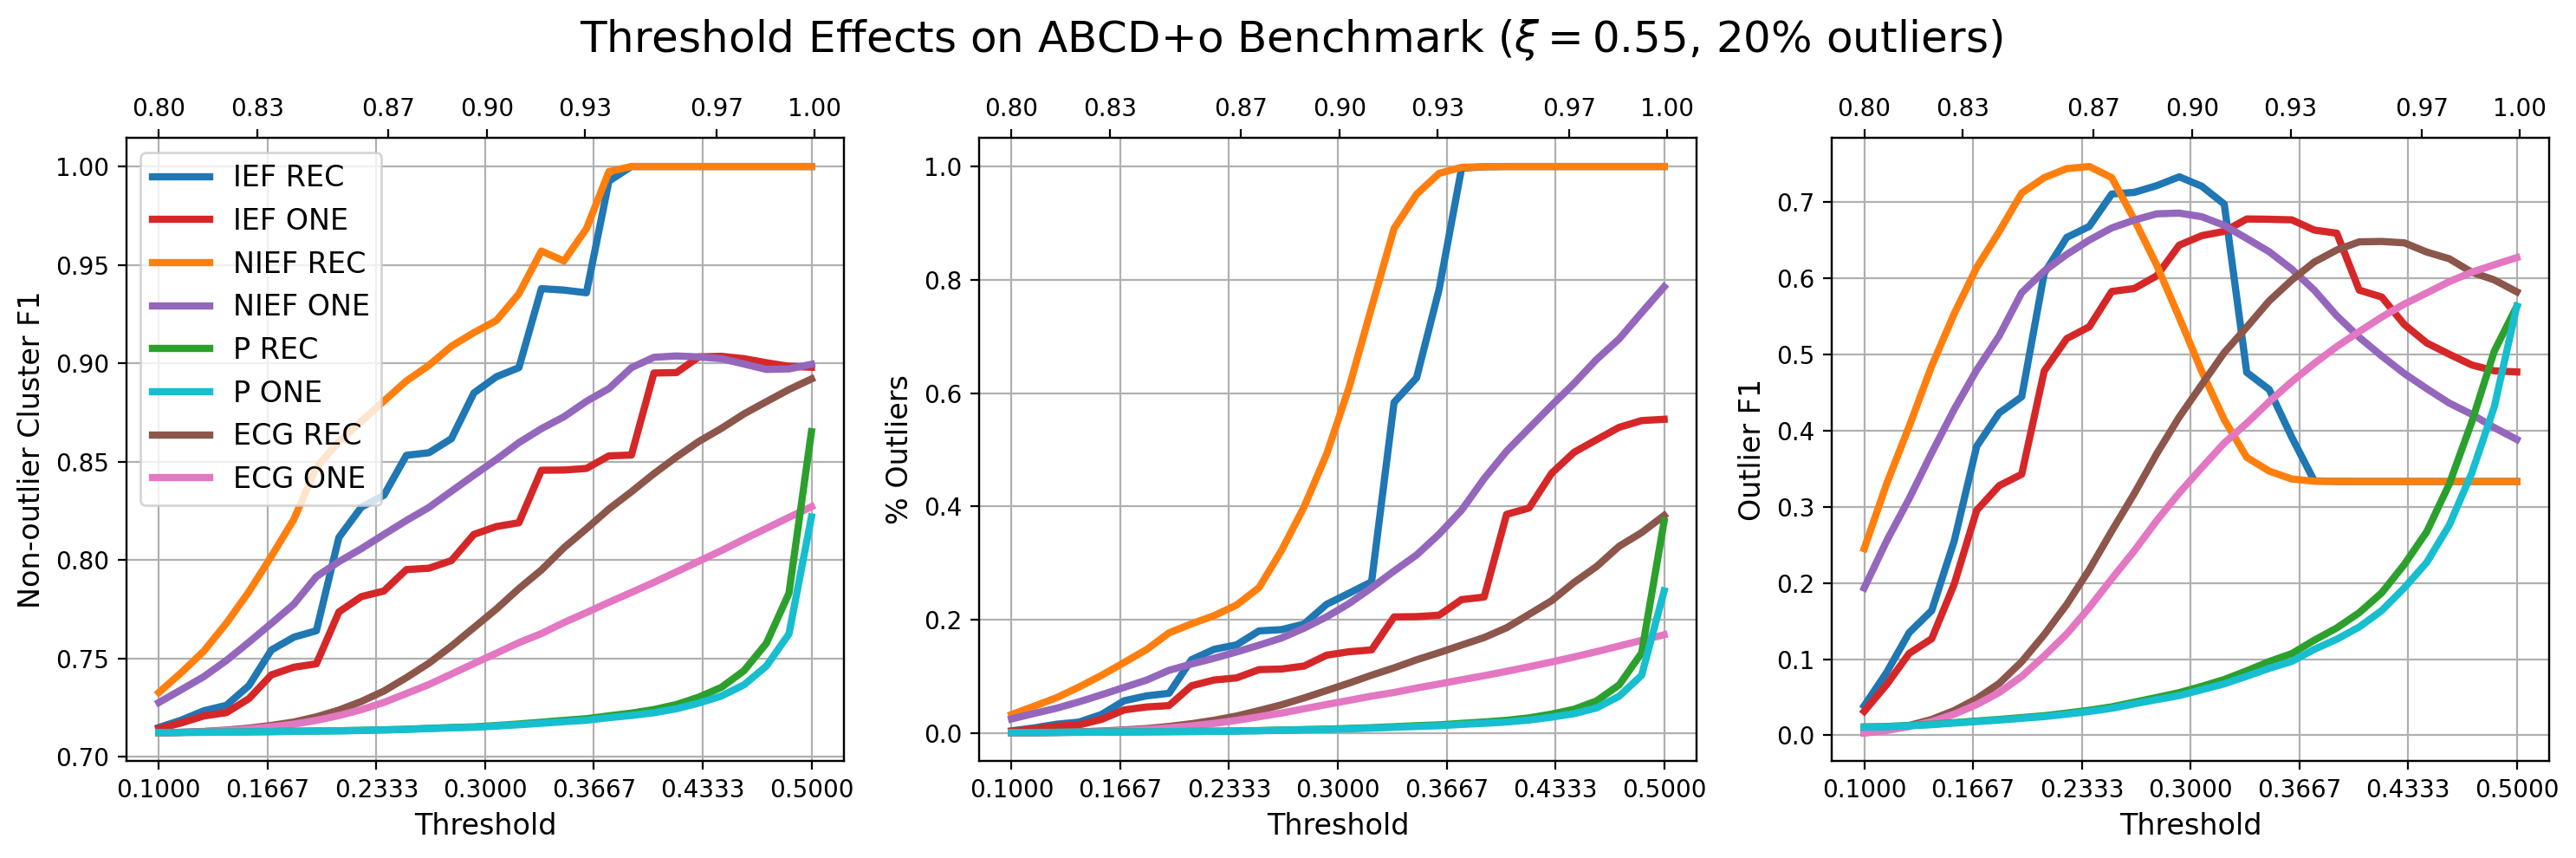

In [8]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
]

fig, axs = plt.subplots(1, 3)
for i in range(3):
    lines = []
    twy = axs[i].twiny()

    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[0, i, :, :], axis=1),
        linewidth=3,
        label="IEF REC",
        c=colors[0],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[1, i, :, :], axis=1),
        linewidth=3,
        label="IEF ONE",
        c=colors[3],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[0, i, :, :], axis=1),
        linewidth=3,
        label="NIEF REC",
        c=colors[1],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[1, i, :, :], axis=1),
        linewidth=3,
        label="NIEF ONE",
        c=colors[4],
    )
    lines += twy.plot(
        p_thresholds,
        np.mean(p[0, i, :, :], axis=1),
        label="P REC",
        linewidth=3,
        c=colors[2],
    )
    lines += twy.plot(
        p_thresholds,
        np.mean(p[1, i, :, :], axis=1),
        label="P ONE",
        linewidth=3,
        c=colors[5],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[0, i, :, :], axis=1),
        linewidth=3,
        label="ECG REC",
        c=colors[6],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[1, i, :, :], axis=1),
        linewidth=3,
        label="ECG ONE",
        c=colors[7],
    )
    labels = [l.get_label() for l in lines]

    # Align tick marks, 5 looks good
    n_ticks = 7
    ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
    axs[i].set_xticks(ief_ticks)
    p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
    twy.set_xticks(p_ticks)
    axs[i].grid()
    # axs[i].set_ylim((-0.01,1.01))

axs[0].set_ylabel("Non-outlier Cluster F1", fontsize=12)
axs[1].set_ylabel("% Outliers", fontsize=12)
axs[2].set_ylabel("Outlier F1", fontsize=12)
axs[0].set_xlabel("Threshold", fontsize=12)
axs[1].set_xlabel("Threshold", fontsize=12)
axs[2].set_xlabel("Threshold", fontsize=12)
axs[0].legend(lines, labels, fontsize=12)
plt.suptitle(
    f"Threshold Effects on ABCD+o Benchmark " + r"$(\xi=0.55$, 20% outliers)",
    fontsize=18,
)

fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.set_dpi(200)
fig.tight_layout()

# Test the threshold vs. overall clustering similarity
3 Heatmaps of xi vs threshold measureing overall F1 cluster similarity

In [27]:
REP = 10
n = 10000
NOUTS = [int(n / 5)]  # np.linspace(n / 100, n / 2, 10, dtype="int32")
XIS = np.round(np.linspace(0.3, 0.7, 10), 2)
ief_thresholds = np.round(np.linspace(0.1, 0.5, 10), 2)
p_thresholds = np.round(np.linspace(0.9, 0.99, 10), 2)

ief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
nief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
p_f1s = np.empty((len(XIS), len(p_thresholds), len(NOUTS), REP))

with tqdm(total=len(NOUTS) * len(XIS) * len(ief_thresholds) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n,
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**0.5),
                    beta=1.5,
                    min_community_size=50,
                    max_community_size=int(n**0.767),
                    xi=xi,
                    num_outliers=nout,
                )
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array(
                    [i for i, com in enumerate(G.communities) for _ in com.vertices]
                )
                labels[labels == np.max(labels)] = -1
                predict = ECG().fit_predict(adjacency)

                for l, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
                    cas_predict = CAS.CASPostProcesser(
                        score="ief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    ief_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="nief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    nief_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="p", threshold=t2
                    ).fit_predict(predict, adjacency)
                    p_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    pbar.update()

100%|██████████| 2025/2025 [14:31<00:00,  2.32it/s]


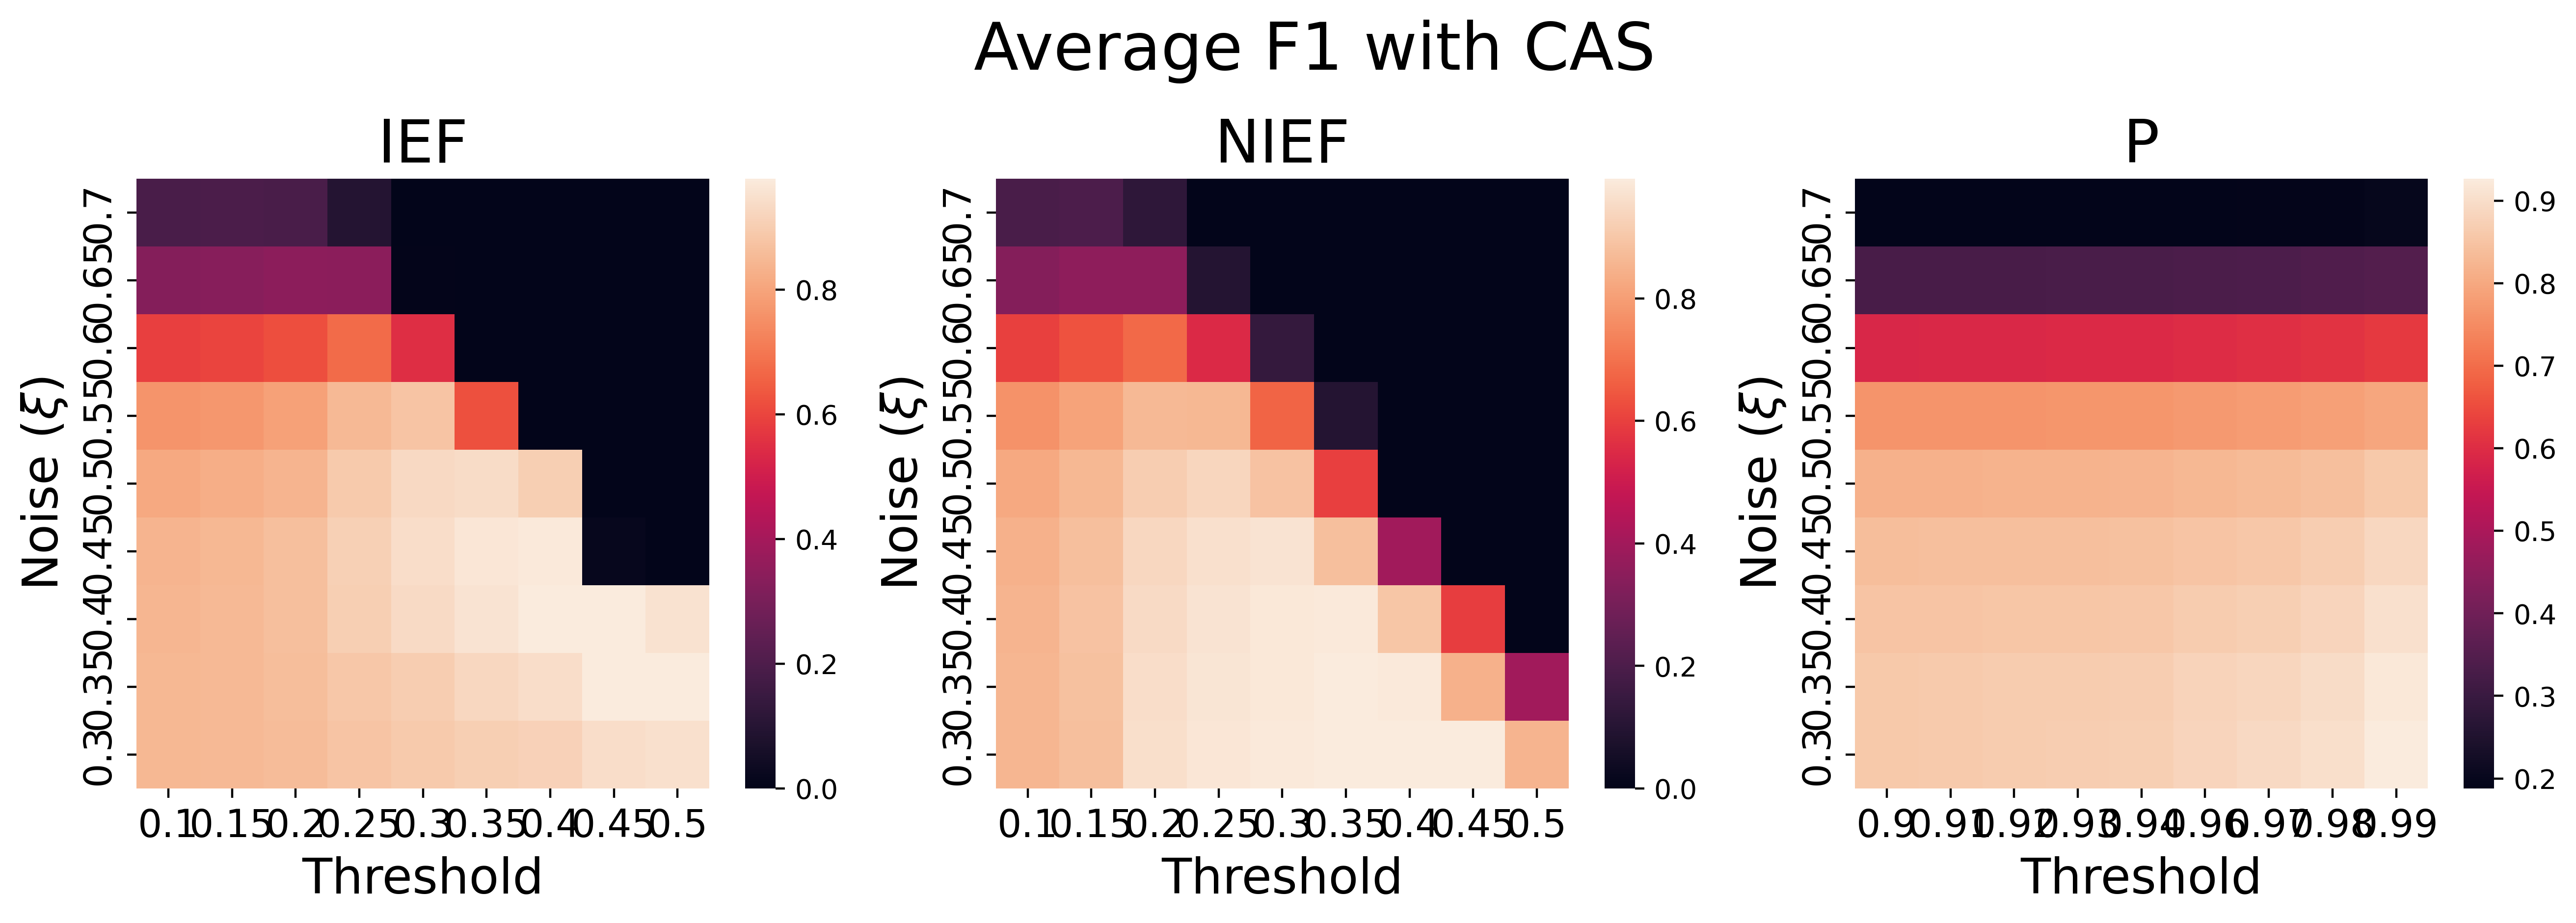

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[0],
)
axs[0].set_xlabel(r"Threshold", fontsize=18)
axs[0].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[1],
)
axs[1].set_xlabel(r"Threshold", fontsize=18)
axs[1].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_f1s, axis=(2, 3)), axis=0),
    xticklabels=p_thresholds,
    yticklabels=XIS[::-1],
    # annot=True,
    # fmt=".2f",
    ax=axs[2],
)
axs[2].set_xlabel(r"Threshold", fontsize=18)
axs[2].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("Average F1 with CAS", fontsize=24, y=0.98)
fig.set_dpi(400)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

# Real Graphs
Test the effect of the threshold on some real world graph datasets with ground truth communities.
We again hope to see that larger thresholds lead to more outliers and a more correct non-outlier clustering.

In [3]:
def load_graph(name):
    adjacency = sp.load_npz(f"data/{name}_adjacency.npz")
    try:
        labels = np.load(f"data/{name}_labels.npy")
    except FileNotFoundError as e:
        try:
            labels = sp.load_npz(f"data/{name}_labels.npz")
        except FileNotFoundError as e:
            raise ValueError("Can't find labels file as npy or npz :(")
    return adjacency, labels

In [8]:
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
ief_thresholds = np.linspace(0.1, 0.6, 30)
p_thresholds = np.linspace(0.9, 0.999, 30)

# Store (Cluster F1, Non-Outlier Cluster F1, % Outlier) in first axis, theshold in second axis, REP in third axis
ief = np.empty((len(graphs), 3, len(ief_thresholds)))
nief = np.empty((len(graphs), 3, len(ief_thresholds)))
ecg = np.empty((len(graphs), 3, len(ief_thresholds)))
p = np.empty((len(graphs), 3, len(p_thresholds)))

for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    if sp.issparse(labels):
        is_outlier = labels.getnnz(0) == 0
    else:
        is_outlier = labels == -1
    ecgo = ECG()
    predict = ecgo.fit_predict(adjacency)
    print("CAS PostProcessing")
    with tqdm(total=len(ief_thresholds)) as pbar:
        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, adjacency
            )
            ief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ief[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t1).fit_predict(
                predict, adjacency
            )
            nief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            nief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            nief[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, ecgo.weights
            )
            ecg[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ecg[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ecg[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            cas_predict = CAS.CASPostProcesser(score="p", threshold=t2).fit_predict(
                predict, adjacency
            )
            p[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            p[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            p[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            pbar.update()

football
CAS PostProcessing


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


eu-core
CAS PostProcessing


100%|██████████| 30/30 [00:01<00:00, 15.68it/s]


as
CAS PostProcessing


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


cora
CAS PostProcessing


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


amazon
CAS PostProcessing


100%|██████████| 30/30 [07:53<00:00, 15.78s/it]


dblp
CAS PostProcessing


100%|██████████| 30/30 [08:53<00:00, 17.78s/it]


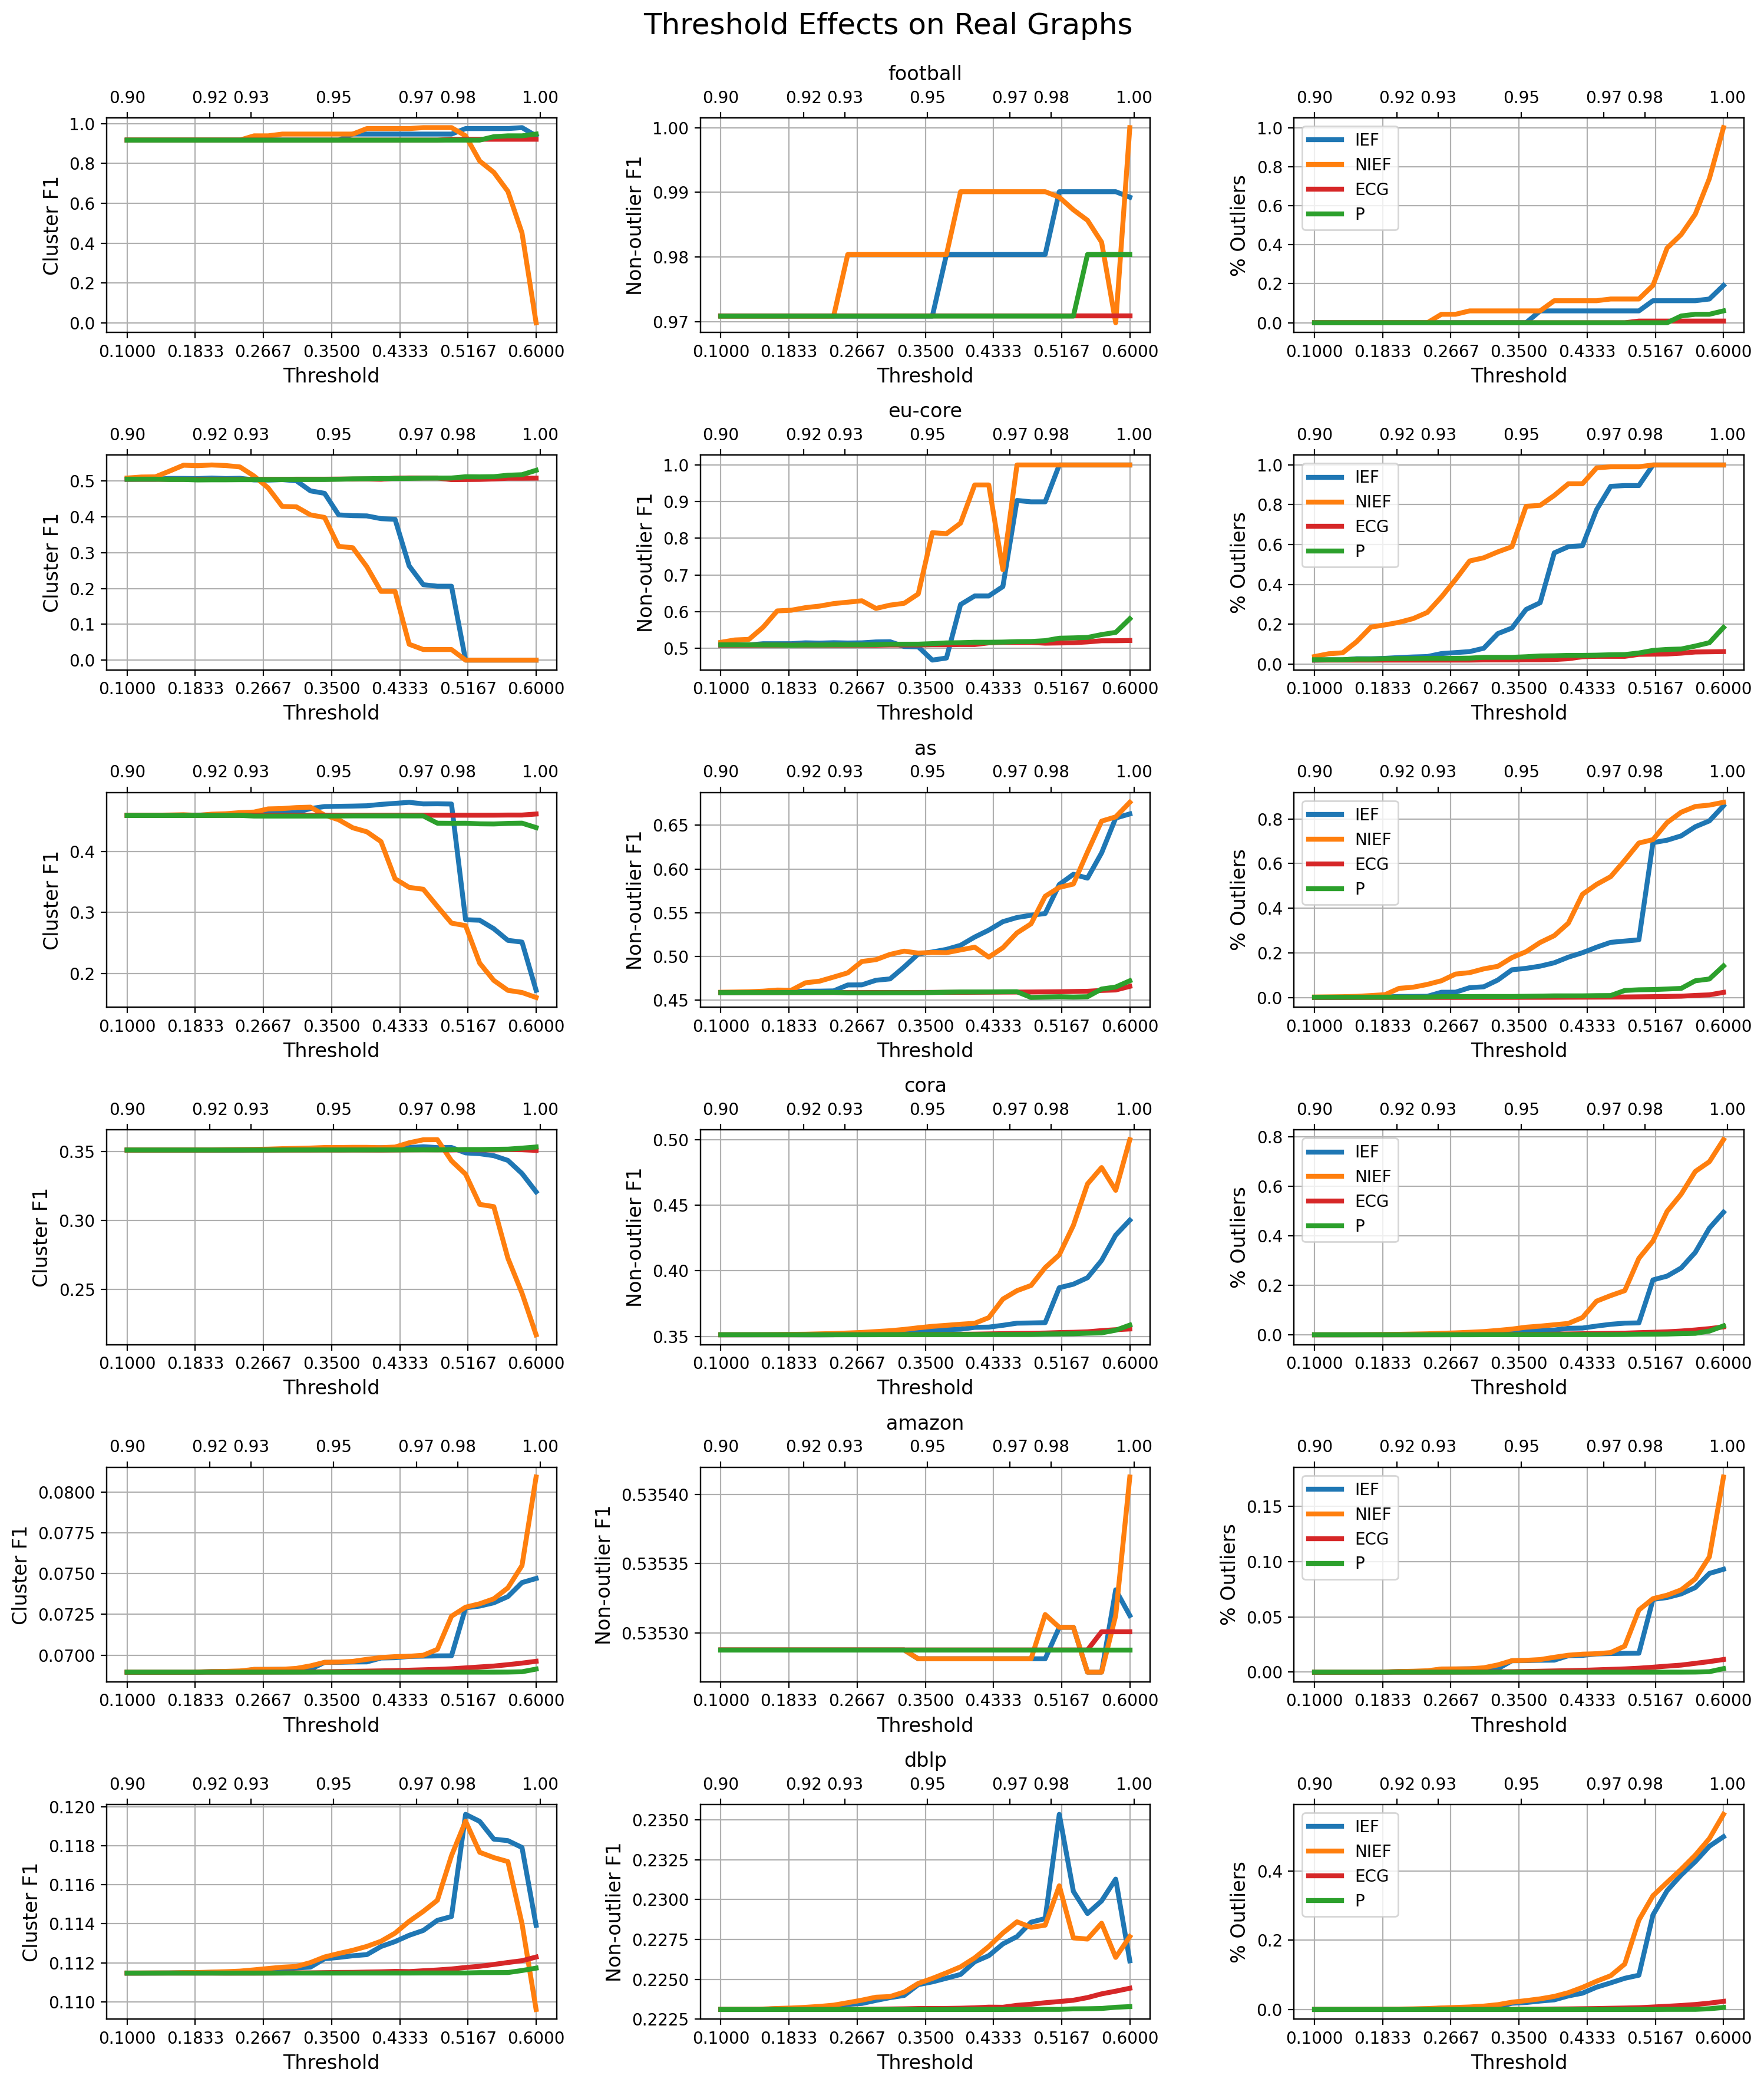

In [9]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

fig, axs = plt.subplots(len(graphs), 3)
for i in range(len(graphs)):
    for j in range(3):
        lines = []
        twy = axs[i, j].twiny()

        lines += axs[i, j].plot(
            ief_thresholds,
            ief[i, j, :],
            linewidth=3,
            label="IEF",
            c=colors[0],
        )
        lines += axs[i, j].plot(
            ief_thresholds,
            nief[i, j, :],
            linewidth=3,
            label="NIEF",
            c=colors[1],
        )
        lines += axs[i, j].plot(
            ief_thresholds,
            ecg[i, j, :],
            linewidth=3,
            label="ECG",
            c=colors[3],
        )
        lines += twy.plot(p_thresholds, p[i, j, :], label="P", linewidth=3, c=colors[2])
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 7
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i, j].set_xticks(ief_ticks)
        p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        twy.set_xticks(p_ticks)
        axs[i, j].grid()
        # axs[i,j].set_ylim((0,1))

    axs[i, 0].set_ylabel("Cluster F1", fontsize=12)
    axs[i, 1].set_ylabel("Non-outlier F1", fontsize=12)
    axs[i, 2].set_ylabel("% Outliers", fontsize=12)
    axs[i, 0].set_xlabel("Threshold", fontsize=12)
    axs[i, 1].set_xlabel("Threshold", fontsize=12)
    axs[i, 2].set_xlabel("Threshold", fontsize=12)
    axs[i, 2].legend(lines, labels)
    axs[i, 1].set_title(graphs[i])
plt.suptitle(
    f"Threshold Effects on Real Graphs",
    fontsize=18,
)
fig = plt.gcf()
fig.set_size_inches(15, 3 * len(graphs))
fig.set_dpi(200)
fig.tight_layout()
fig.subplots_adjust(top=0.93)  # Make room for suptitle

## Internal cluster quality metrics
Check that CAS-Postprocessing improves the quality of each cluster based on some internal metrics of cluster quality.
We hope that the clusters "look-better" after post-processing.

In [4]:
t = 0.4
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
data = np.empty((len(graphs), 6, 6))
for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    ecgo = ECG()
    predict = CAS.labels_array_to_matrix(ecgo.fit_predict(adjacency))
    predict_conductance = np.nanmean(ce.conductance(adjacency, predict))
    predict_cc = np.nanmean(ce.clustering_coefficient(adjacency, predict))
    predict_density = np.nanmean(ce.density(adjacency, predict))
    predict_cut_ratio = np.nanmean(ce.cut_ratio(adjacency, predict))
    predict_expansion = np.nanmean(ce.expansion(adjacency, predict))
    predict_modularity = np.nanmean(ce.modularity(adjacency, predict))

    ief_rec = CAS.CASPostProcesser(score="ief", threshold=t).fit_predict(
        predict, adjacency
    )
    ief_one = CAS.CASPostProcesser(score="ief", threshold=t, max_rounds=1).fit_predict(
        predict, adjacency
    )

    nief_rec = CAS.CASPostProcesser(score="nief", threshold=t).fit_predict(
        predict, adjacency
    )
    nief_one = CAS.CASPostProcesser(
        score="nief", threshold=t, max_rounds=1
    ).fit_predict(predict, adjacency)

    ecg_rec = CAS.CASPostProcesser(score="ief", threshold=t).fit_predict(
        predict, adjacency
    )
    ecg_one = CAS.CASPostProcesser(score="ief", threshold=t, max_rounds=1).fit_predict(
        predict, ecgo.weights
    )

    for j, cas in enumerate([ief_rec, ief_one, nief_rec, nief_one, ecg_rec, ecg_one]):
        cas_conductance = np.nanmean(ce.conductance(adjacency, cas))
        cas_cc = np.nanmean(ce.clustering_coefficient(adjacency, cas))
        cas_density = np.nanmean(ce.density(adjacency, cas))
        cas_cut_ratio = np.nanmean(ce.cut_ratio(adjacency, cas))
        cas_expansion = np.nanmean(ce.expansion(adjacency, cas))
        cas_modularity = np.nanmean(ce.modularity(adjacency, cas))

        data[i, j, 0] = cas_density - predict_density
        data[i, j, 1] = cas_cc - predict_cc
        data[i, j, 2] = cas_modularity - predict_modularity
        data[i, j, 3] = cas_conductance - predict_conductance
        data[i, j, 4] = cas_expansion - predict_expansion
        data[i, j, 5] = cas_cut_ratio - predict_cut_ratio

football
eu-core
as
cora
amazon
dblp


In [7]:
print(f"         | Density |   CC   | Modularity | Conductance | Cut Ratio | Expansion")
for j, score in enumerate(
    ["IEF REC", "IEF ONE", "NIEF REC", "NIEF ONE", "ECG REC", "ECG ONE"]
):
    print()
    print(f"{score:.14s}")
    for i, name in enumerate(graphs):
        print(
            f"{name:8s} | {data[i, j, 0]:7.3f} | {data[i, j, 1]:6.3f} | {data[i, j, 2]:10.3f} | {data[i, j, 3]:11.3f} | {data[i,j,5]:9.3f} | {data[i, j, 4]:9.3f}"
        )

         | Density |   CC   | Modularity | Conductance | Cut Ratio | Expansion

IEF REC
football |   0.025 |  0.024 |     -0.001 |      -0.003 | -0.00034651 |    -0.015
eu-core  |   0.009 |  0.071 |      0.005 |       0.242 | 0.00449847 |     4.329
as       |  -0.038 | -0.013 |     -0.000 |      -0.016 | -0.00000698 |    -0.151
cora     |   0.000 |  0.002 |     -0.000 |      -0.005 | -0.00000146 |    -0.032
amazon   |   0.000 |  0.001 |     -0.000 |      -0.002 | -0.00000003 |    -0.009
dblp     |   0.000 |  0.003 |     -0.000 |      -0.006 | -0.00000015 |    -0.049

IEF ONE
football |   0.015 |  0.016 |     -0.000 |      -0.000 | -0.00006884 |     0.005
eu-core  |  -0.001 | -0.006 |      0.006 |       0.290 | 0.00745636 |     6.650
as       |  -0.038 | -0.013 |     -0.000 |      -0.001 | -0.00000489 |    -0.109
cora     |   0.000 |  0.002 |     -0.000 |      -0.004 | -0.00000129 |    -0.029
amazon   |   0.000 |  0.001 |     -0.000 |      -0.002 | -0.00000002 |    -0.008
dblp     |   0